  Copyright(c) 2021 UNIADEX, Ltd. All Rights Reserved.  
  CONFIDENTIAL  
  Author: UNIADEX, Ltd.

# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットから特徴点を抽出するサンプルコードです。抽出した特徴点はElasticsearchに格納されます。

In [1]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../src/'))
from data_reader.data_reader import DataReader
from elastic_manager.elastic_manager import ElasticManager
sys.path.append(os.path.join(os.getcwd(), '../src/analyze/'))
from analyze.h_one_extract_features import *
from analyze.analyze import *

Loading BokehJS ...

In [2]:
# ログ設定
LOG_FILE = os.path.join(
    common.get_config_value(common.APP_CONFIG_PATH, "log_dir"), "analyze/analyze.log"
)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.handlers.RotatingFileHandler(
            LOG_FILE, maxBytes=common.MAX_LOG_SIZE, backupCount=common.BACKUP_COUNT
        ),
        logging.StreamHandler(),
    ],
)

In [3]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-20210327141514-data,13590838,1920942
1,shots-20210617130000-data,40308,5982


In [4]:
# 対象データ設定
target = "20210327141514"
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

# 1ショットで特徴点抽出

## ショット1番を取得して確認

In [5]:
dr = DataReader()

shot_number = 50
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,rawdata_sequential_number,displacement,load01,load02,load03,load04,shot_number,tags
0,2021-03-27T05:22:44.615197,459350,0,46398509,51.79125,0.021,0.083,0.042,0.123,50,[]
1,2021-03-27T05:22:44.615207,459351,1,46398510,51.79125,0.016,0.087,0.031,0.123,50,[]
2,2021-03-27T05:22:44.615217,459352,2,46398511,51.79125,0.014,0.089,0.011,0.117,50,[]
3,2021-03-27T05:22:44.615227,459353,3,46398512,51.78250,0.013,0.083,-0.017,0.101,50,[]
4,2021-03-27T05:22:44.615237,459354,4,46398513,51.78250,0.013,0.070,-0.044,0.083,50,[]


In [6]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,shot_number,spm,num_of_samples_in_cut_out
0,1,50.847458,109404.0
1,2,NaN,16564.0
2,3,28.571429,9877.0
3,4,32.608696,8640.0
4,5,35.928144,7798.0


In [7]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：3264


In [8]:
# 80spmを超えるような不正なショットがないか確認
pd.set_option('display.max_rows', 3300)
shots_meta_df[shots_meta_df.spm > 80]

,shot_number,spm,num_of_samples_in_cut_out
981,982,400.000000,3878.0
982,983,100.000000,1019.0
1367,1368,400.000000,3866.0
1368,1369,100.000000,1019.0
1379,1380,461.538462,3896.0
1380,1381,96.774194,1018.0
2892,2893,428.571429,3840.0
2893,2894,100.000000,1019.0


In [9]:
# spm
spm = float(shots_meta_df[shots_meta_df.shot_number == 1].spm)
print(f"spm：{spm}")

spm：50.847457627118644


## 特徴点抽出
1ショットから最大荷重点、荷重開始点、破断点を取得します。  

***shot_data***: 対象ショットデータ  
***spm***: spm  
***func***：適用するロジック  
***sub_func***：サブロジック  
***disp_chart***: グラフ表示

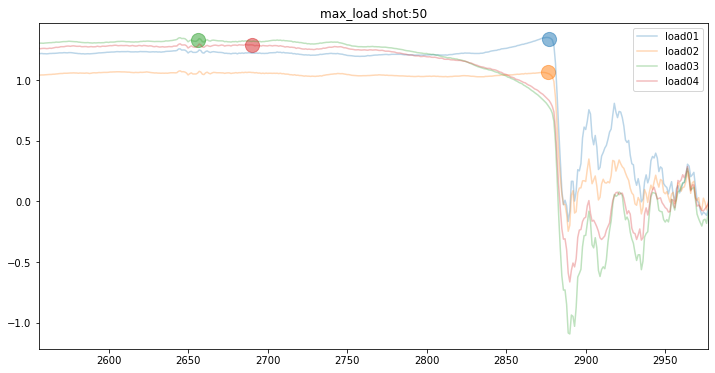

2021-06-18 14:15:16,328 [INFO] NumExpr defaulting to 8 threads.


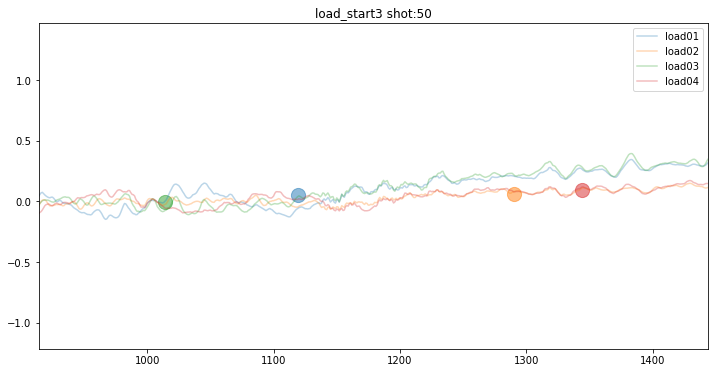

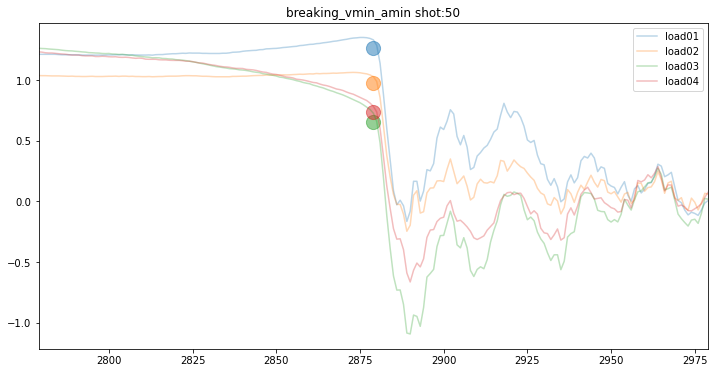

In [10]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values, debug_values = extract_features(shot_data=shot_df, spm=spm, func=max_load, shot=shot_number, disp_chart=True)
load_start_indicies, load_start_values, debug_values = extract_features(shot_df, spm, load_start3, shot=shot_number, disp_chart=True)
break_load_indicies, break_load_values, debug_values = extract_features(shot_df, spm, breaking_vmin_amin, sub_func=narrowing_v4min_mab, shot=shot_number, disp_chart=True)

In [11]:
# 各特徴点のインデックス番号と値を確認
print(f"【最大荷重点】\n indicies：{max_load_indicies}, values：{max_load_values}")
print(f"【荷重開始点】\n indicies：{load_start_indicies}, values：{load_start_values}")
print(f"【破断点】　　\n indicies：{break_load_indicies}, values：{break_load_values}")

【最大荷重点】
 indicies：[2877, 2876, 2656, 2690], values：[1.3358001363065923, 1.0667658742915898, 1.3318410909930898, 1.2881683870466936]
【荷重開始点】
 indicies：[1119, 1290, 1014, 1344], values：[0.05387969924812029, 0.06362656641604017, -0.002401002506265687, 0.09729323308270675]
【破断点】　　
 indicies：[2879, 2879, 2879, 2879], values：[1.265996061349155, 0.9724871649936309, 0.6566632503189952, 0.7354230047877176]


# 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータのDataFrame
***shots_meta_df***: ショットメタデータのDataFrame  
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  
***exclude_shots***: 除外ショット(ex: exclude_shots=(1227, 1228, 1229))  

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [12]:
# 対象指定
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

In [13]:
%%time
dr = DataReader()
shots_df = dr.multi_process_read_all(shots_data_index)

2021-06-18 14:16:11,305 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-06-18 14:16:11,309 [INFO] Data read start. data_count: 13590838.


CPU times: user 1min 51s, sys: 9.38 s, total: 2min 1s
Wall time: 4min 7s


In [14]:
# ショットメタデータ読み込み
shots_meta_df = dr.read_shots_meta(shots_meta_index)

## 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータ  
***shots_meta_df***: ショットメタデータ  
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  
***exclude_shots***：除外するショット番号（例：exclude_shots=(1227, 1228, 1229)）

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [15]:
# 不正ショットの除外
exclude_shots=(983, 1227, 1228, 1229, 1369, 1381, 2894)

In [16]:
# 最大荷重点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="max",
    func=ef.max_load,
    sub_func=None,
    exclude_shots=exclude_shots
)

2021-06-18 14:20:26,529 [INFO] apply start.
2021-06-18 14:20:26,604 [INFO] delete index 'shots-20210327141514-max-point' finished. result: {'acknowledged': True}
2021-06-18 14:20:27,390 [INFO] shot_number: 1227 was excluded.
2021-06-18 14:20:27,491 [INFO] shot_number: 1228 was excluded.
2021-06-18 14:20:27,495 [INFO] shot_number: 1229 was excluded.
2021-06-18 14:20:30,241 [INFO] shot_number: 2894 was excluded.
2021-06-18 14:20:34,666 [INFO] shot_number: 1369 was excluded.
2021-06-18 14:20:35,199 [INFO] shot_number: 1381 was excluded.
2021-06-18 14:20:35,363 [INFO] shot_number: 983 was excluded.
2021-06-18 14:20:49,153 [INFO] apply finished.


In [17]:
dr = DataReader()
max_index = "shots-" + target + "-max-point"
max_df = dr.read_all(max_index)
max_df

2021-06-18 14:20:53,808 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-06-18 14:20:53,811 [INFO] データ件数: 13028
2021-06-18 14:20:53,964 [INFO] Data reading has finished.


,timestamp,shot_number,load,sequential_number,sequential_number_by_shot,value
0,2021-03-27T05:16:25.190134,1,load04,4943,4943,0.155258
1,2021-03-27T05:16:25.197834,1,load01,5712,5712,0.283157
2,2021-03-27T05:16:25.200218,1,load02,5950,5950,0.127714
3,2021-03-27T05:16:25.203432,1,load03,6271,6271,0.339230
4,2021-03-27T05:16:26.408576,2,load01,117929,8525,1.159921
...,...,...,...,...,...,...
13023,2021-03-27T06:42:05.329692,3263,load01,13574938,5260,1.905189
13024,2021-03-27T06:42:25.240645,3264,load03,13585120,4964,1.184347
13025,2021-03-27T06:42:25.241236,3264,load04,13585179,5023,1.224862
13026,2021-03-27T06:42:25.246694,3264,load01,13585724,5568,1.714805


In [19]:
# 荷重開始点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="start",
    func=load_start3,
    sub_func=None,
    exclude_shots=exclude_shots 
)

2021-06-18 14:21:04,654 [INFO] apply start.
2021-06-18 14:21:04,723 [INFO] delete index 'shots-20210327141514-start-point' finished. result: {'acknowledged': True}
2021-06-18 14:21:05,528 [INFO] shot_number: 1227 was excluded.
2021-06-18 14:21:05,768 [INFO] shot_number: 1228 was excluded.
2021-06-18 14:21:05,916 [INFO] shot_number: 1229 was excluded.
2021-06-18 14:21:08,944 [INFO] shot_number: 2894 was excluded.
2021-06-18 14:21:16,624 [INFO] shot_number: 1369 was excluded.
2021-06-18 14:21:17,379 [INFO] shot_number: 983 was excluded.
2021-06-18 14:21:17,509 [INFO] shot_number: 1381 was excluded.
2021-06-18 14:21:37,292 [INFO] apply finished.


In [20]:
dr = DataReader()
start_index = "shots-" + target + "-start-point"
start_df = dr.read_all(start_index)
start_df

2021-06-18 14:23:47,396 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-06-18 14:23:47,400 [INFO] データ件数: 13028
2021-06-18 14:23:47,553 [INFO] Data reading has finished.


,timestamp,shot_number,load,sequential_number,sequential_number_by_shot,value
0,2021-03-27T05:16:25.165220,1,load03,2455,2455,-0.011168
1,2021-03-27T05:16:25.165611,1,load01,2494,2494,0.001193
2,2021-03-27T05:16:25.166983,1,load02,2631,2631,-0.001962
3,2021-03-27T05:16:25.167113,1,load04,2644,2644,-0.004366
4,2021-03-27T05:16:26.366950,2,load04,113772,4368,0.004363
...,...,...,...,...,...,...
13023,2021-03-27T06:42:05.291611,3263,load02,13571135,1457,-0.009293
13024,2021-03-27T06:42:25.205047,3264,load01,13581565,1409,-0.018143
13025,2021-03-27T06:42:25.205358,3264,load03,13581596,1440,-0.044704
13026,2021-03-27T06:42:25.205808,3264,load04,13581641,1485,-0.027687


In [21]:
# 破断点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="break",
    func=breaking_vmin_amin,
    sub_func=narrowing_v4min_mab,
    exclude_shots=exclude_shots    
)

2021-06-18 14:23:49,154 [INFO] apply start.
2021-06-18 14:23:49,223 [INFO] delete index 'shots-20210327141514-break-point' finished. result: {'acknowledged': True}
2021-06-18 14:23:50,008 [INFO] shot_number: 1227 was excluded.
2021-06-18 14:23:50,293 [INFO] shot_number: 1228 was excluded.
2021-06-18 14:23:50,295 [INFO] shot_number: 1229 was excluded.
2021-06-18 14:23:52,796 [INFO] shot_number: 2894 was excluded.
2021-06-18 14:23:58,773 [INFO] shot_number: 1369 was excluded.
2021-06-18 14:23:59,489 [INFO] shot_number: 1381 was excluded.
2021-06-18 14:23:59,619 [INFO] shot_number: 983 was excluded.
2021-06-18 14:24:16,437 [INFO] apply finished.


In [22]:
dr = DataReader()
break_index = "shots-" + target + "-break-point"
break_df = dr.read_all(break_index)
break_df

2021-06-18 14:24:24,014 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-06-18 14:24:24,017 [INFO] データ件数: 13028
2021-06-18 14:24:24,169 [INFO] Data reading has finished.


,timestamp,shot_number,load,sequential_number,sequential_number_by_shot,value,break_channels
0,2021-03-27T05:16:25.203382,1,load01,6266,6266,0.276385,"[load01, load02]"
1,2021-03-27T05:16:25.203382,1,load02,6266,6266,0.128082,"[load01, load02]"
2,2021-03-27T05:16:25.203382,1,load03,6266,6266,0.348574,"[load01, load02]"
3,2021-03-27T05:16:25.203382,1,load04,6266,6266,0.162974,"[load01, load02]"
4,2021-03-27T05:16:26.419401,2,load04,119010,9606,1.230244,"[load01, load02]"
...,...,...,...,...,...,...,...
13023,2021-03-27T06:42:05.330634,3263,load04,13575032,5354,-0.028044,"[load03, load04]"
13024,2021-03-27T06:42:25.247174,3264,load02,13585772,5616,1.317613,"[load03, load04]"
13025,2021-03-27T06:42:25.247184,3264,load01,13585773,5617,1.460389,"[load03, load04]"
13026,2021-03-27T06:42:25.247254,3264,load03,13585780,5624,-0.430173,"[load03, load04]"


In [32]:
break_df.head(10)

,shot_number,load,sequential_number,sequential_number_by_shot,value,break_channels
0,1,load01,6266,6266,0.276385,"[load01, load02]"
1,1,load02,6266,6266,0.128082,"[load01, load02]"
2,1,load03,6266,6266,0.348574,"[load01, load02]"
3,1,load04,6266,6266,0.162974,"[load01, load02]"
4,2,load04,119010,9606,1.230244,"[load01, load02]"
5,2,load03,119011,9607,1.440953,"[load01, load02]"
6,2,load01,119015,9611,-0.684402,"[load01, load02]"
7,2,load02,119015,9611,-0.191011,"[load01, load02]"
8,3,load03,131230,5262,1.834161,"[load01, load02]"
9,3,load04,131230,5262,1.473786,"[load01, load02]"
